<a href="https://colab.research.google.com/github/shryu8902/KAERI_mini_BS/blob/main/%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C_2_2_PyOD_%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%9D%B4%EC%83%81%ED%83%90%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyOD 라이브러리를 활용한 이상탐지 실습자료

본 실습자료에서는 PyOD 라이브러리를 활용하여 대표적인 머신러닝 기반 이상탐지 방법의 예제를 살펴보도록 하겠습니다.

1. IRIS 데이터를 활용한 hold-out class 이상탐지 셋팅
2. PyOD 라이브러리를 활용한 이상탐지 모델 학습
3. 이상 탐지 성능 판단

## 라이브러리 준비

먼저 아래의 코드를 통해 필요 라이브러리를 불러옵니다.

In [1]:
!pip install PyOD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pyod


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyOD: filename=pyod-1.0.9-py3-none-any.whl size=184112 sha256=7019ba963617ca2cd4b7c3c8a7f6a7f290ab9c3bbd136fa83f636024d3ead550
  Stored in directory: /root/.cache/pip/wheels/1b/9c/b8/9759d7cc64a1e01bb9872ade80cb7db445ccf506e083325106
Successfully built PyOD


## 데이터셋 준비

널리 알려진 IRIS 데이터셋을 활용해보도록 하겠습니다.
먼저 iris 데이터를 불러와서 데이터셋을 대략적으로 살펴보도록 하겠습니다.

In [2]:
from sklearn import datasets
iris = datasets.load_iris()

In [3]:
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['label']=iris.target

In [4]:
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


IRIS 데이터는 4개의 변수로 구성되어있으며 setosa, versicolor, verginica class로 구분됩니다. 
PCA를 통해 2차원 공간상에서 데이터가 어떻게 분포되어있는지 살펴보도록 하겠습니다.

<Axes: >

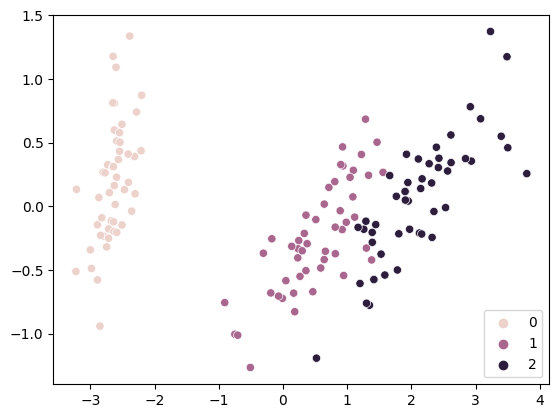

In [6]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_iris = pca.fit_transform(iris.data)
sns.scatterplot(x=pca_iris[:,0],y=pca_iris[:,1], hue = iris.target)

### 이상탐지 데이터셋 구성

이제 IRIS를 활용하여 이상 탐지 문제를 위한 데이터셋을 구성해보도록하겠습니다.

본 예제에서는 setosa (label=0), versicolor(label=1)를 정상 데이터로, virginica(label=2)를 비정상 데이터로 가정하여  데이터셋을 구성하도록 하겠습니다.

또한 비정상 데이터의 일부를 학습데이터에 포함시켜 
비지도학습 기반의 이상탐지 문제로 구성하였습니다.

학습데이터는 순서대로 setosa, versicolor 각각 40개씩, 그리고 virginica에서 10개를 뽑아서 구성하였고, 나머지 데이터는 테스트셋으로 만들었습니다.

따라서 학습 데이터셋중 약 10% 가 비정상 데이터이며, PyOD 라이브러리에서 이러한 비율을 고려할수 있는 모델은 contamination이라는 파라미터를 입력받아 사용할 수 있습니다.
(본 예제에서는 contamination = 0.1로 사용하겠습니다.)

In [7]:
data_per_class =[iris.data[iris.target==i] for i in range(3)]
train_set = np.concatenate([data_per_class[0][:40,:], data_per_class[1][:40,:], data_per_class[2][:10,:]])
test_set = np.concatenate([data_per_class[0][40:,:], data_per_class[1][40:,:], data_per_class[2][10:,:]])
label = np.concatenate([np.zeros(20), np.ones(40)])
contam = 10/90

## PyOD 라이브러리 활용

데이터셋이 준비되어있으므로 이제 PyOD 라이브러리를 활용하여 
다양한 이상탐지 모델들의 결과를 비교해보도록 하겠습니다.

PyOD 라이브러리에서는 다양한 이상탐지 모델들을 지원하므로, 자세한 내용은 공식 document를 참고하시면 됩니다.
https://pyod.readthedocs.io/en/latest/index.html

본 예제에서는 k-nearest neighbor, isolation forest와 발표자료에서 살펴보았던 ocsvm, deep svdd, autoencoder, variational autoencoder 모델에 대한 이상탐지 결과를 비교해 보도록 하겠습니다.

PyOD에서는 autoencoder, DSVDD와 같은 신경망 모델도 지원하지만 이를 위해서는 torch나 tensorflow가 함께 사용되어야 합니다.

각 모델 별 hyperparameter는 라이브러리 기본값을 사용하였습니다 (신경망 모델 제외).

In [8]:
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.vae import VAE
import tensorflow

In [9]:
models = {'KNN':KNN(contamination = contam),
          'ISOF':IForest(contamination = contam),
          'OCSVM':OCSVM(contamination = contam),
          'DSVDD':DeepSVDD(epochs=50, batch_size=8,contamination = contam),
          'AE':AutoEncoder(hidden_neurons = [32,8, 2, 8, 32], epochs=50, batch_size=8,contamination = contam),
          'VAE':VAE(encoder_neurons = [32,8,2], decoder_neurons = [2,8,32], epochs=50, batch_size=8, contamination = contam)}
scores={'label':label}
decisions={'label':label}

In [10]:
for key in models:
    models[key].fit(train_set)
    score = models[key].decision_function(test_set)
    result = models[key].predict(test_set)
    scores[key] = score
    decisions[key] = result

3/3 [==============================] - 0s 3ms/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 64)                256       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_1 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_1 (TFOpL  (None,)                  0         
 ambda) 

## 결과 정리

이제 PyOD 모델별로 이상탐지 성능 평가 결과를 비교해보도록하겠습니다.

다음의 코드를 통해 모델별로 ROC 그래프와 AUROC를 계산하였습니다.

In [11]:
df_scores = pd.DataFrame(scores)

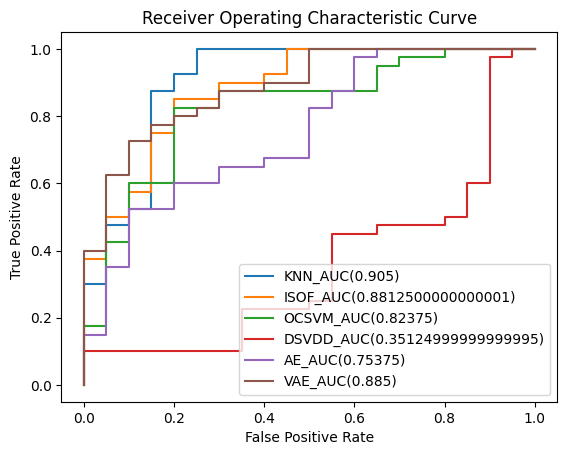

In [12]:
from sklearn import metrics


for i, key in enumerate(models):
    fpr,tpr, thresh = metrics.roc_curve(df_scores.label, df_scores[key])
    auc = metrics.auc(fpr,tpr)
    plt.plot(fpr, tpr, label = key + '_AUC({})'.format(auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()


다음은 contamination 비율에 따라 pyod에서 자동적으로 설정된 threshold를 기준으로 모델별 최종 정상/이상 분류결과에 대한 그래프입니다.
X축은 각 입력 데이터의 인덱스이고 Y축은 모델별 최종 분류 결과입니다. (0 : 정상, 1 : 비정상)

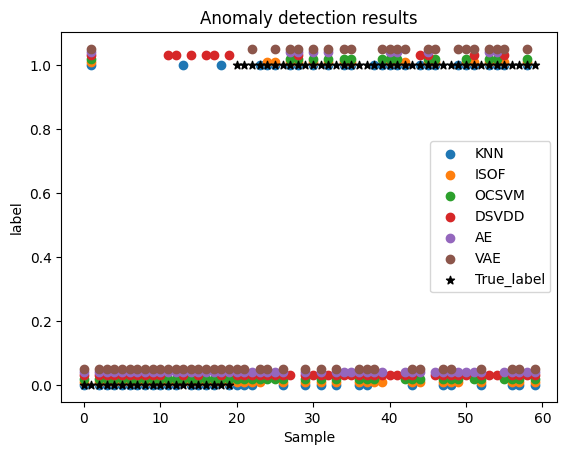

In [13]:
df_result = pd.DataFrame(decisions)

for i, key in enumerate(models):
    plt.scatter(np.arange(60), df_result[key]+i*0.01, label = key)
plt.scatter(np.arange(60), df_result.label, marker='*',color='k', label = 'True_label')

plt.xlabel('Sample')
plt.ylabel('label')
plt.title('Anomaly detection results')
plt.legend()

지금까지 IRIS 데이터셋과 PyOD 라이브러리를 활용하여 간단한 이상탐지 모델을 학습시키고 이상탐지 결과를 비교해보았습니다. 

이상탐지 문제에서는 데이터셋에따라 모델별 성능이 상이 할 수 있으며, 

PyOD 라이브러리를 활용하면 다양한 모델에 대한 적용 결과를 쉽게 확인 할 수 있습니다.